## Environment Setup
Install dependent packages and define helper functions.

We assume you have already have pytorch, numpy and tqdm installed. For reproducibility, we depend on the following packages:

[Diffusers](https://huggingface.co/docs/diffusers/en/index) version 0.12.1, you can install it by running following block if 
you haven't already.

In [1]:
!pip install diffusers==0.12.1

Here we define some helper functions to display the generated samples in notebook (display_sampl()) and
a "random" noise generator (random_tensor). There are also the reproducibility code, you must run this before
you submit your notebook.

In [2]:
from diffusers import UNet2DModel
from diffusers import DDPMScheduler
import tqdm
import torch
import PIL.Image
import numpy as np


def display_sample(sample, i):
    """
    Display the processed image sample.
    Args:
        sample (torch.Tensor): The processed image sample.
        i (int): The step number.
    """
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

def randn_tensor(shape, generator=None, device=None, dtype=None, layout=None):
    rand_device = device

    layout = layout or torch.strided
    device = device or torch.device("cpu")

    return torch.randn(
        shape,
        generator=generator,
        device=rand_device,
        dtype=dtype,
        layout=layout,
    ).to(device)

Here is the way to download pre-trained diffusion model from HuggingFace, you can use similar code to download different
diffusion models by exploring their [hub](https://huggingface.co/models).

Note: in this coursework, you must use "google/ddpm-church-256" model!

In [3]:
torch.manual_seed(0)

repo_id = "google/ddpm-church-256"
model = UNet2DModel.from_pretrained(repo_id)
model.to("cuda")

noisy_sample = torch.randn(
    1,
    model.config.in_channels,
    model.config.sample_size,
    model.config.sample_size,
)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


## Question One: Define CustomDDPMScheduler for q-sample

q-sample scheduler is used to create ground truth $x_t$ for training the noise network (DDPM) or score network (Score DM). 
Here we define a class used to create $x_t$ for $t \in [0, ..., 1000]$.

Here, we define a class called `CustomDDPMScheduler_q` to implement q-sample. This class has three functions:
`sqrt_alpha_prod()`
`sqrt_one_minus_alpha_prod()`
and the main interface function called `add_noise()`.

In this question, you should finish these three functions and make them work together,
You may find Equation 2 and 4 in [DDPM](https://proceedings.neurips.cc/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf) help.

In [4]:
class CustomDDPMScheduler_q:
    def __init__(
        self,
        num_train_timesteps,
        beta_start,
        beta_end,
    ):
        # This the basic setting for a 1000 tiemsteps Diffusion Model, and we have
        # defined the betas and alphas and alphas_cumprod for you.
        self.num_inference_steps = 1000
        self.timesteps = torch.from_numpy(
            np.arange(0, num_train_timesteps)[::-1].copy()
        )

        self.betas = torch.linspace(
            beta_start, beta_end, num_train_timesteps
        ).to("cuda")
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = (1 - self.betas).cumprod(dim=0)
        

    def sqrt_alpha_prod(self, timesteps, original_samples):
        sqrt_alpha_prod = torch.sqrt(self.alphas_cumprod[timesteps]).to("cuda")

        return sqrt_alpha_prod

    def sqrt_one_minus_alpha_prod(self, timesteps, original_samples):
        sqrt_one_minus_alpha_prod = torch.sqrt(1 - self.alphas_cumprod[timesteps]).to("cuda")

        return sqrt_one_minus_alpha_prod

    def add_noise(
        self,
        original_samples,
        noise,
        timesteps,
    ):
        # Calculate the square roots of alpha and (1 - alpha) cumulative products
        sqrt_alpha_prod = self.sqrt_alpha_prod(timesteps, original_samples)
        sqrt_one_minus_alpha_prod = self.sqrt_one_minus_alpha_prod(timesteps, original_samples)

        # Add noise to the samples based on the calculated square roots
        noisy_samples = sqrt_alpha_prod * original_samples.to("cuda") + sqrt_one_minus_alpha_prod * noise.to("cuda")

        return noisy_samples.cpu()

In [5]:
# p sample
scheduler = CustomDDPMScheduler_q(1000, 0.0001, 0.02)

# NOTE: Here you must use the npy file which you can find with this notebook!
sample = np.load("tensor.npy")
noisy_sample = torch.tensor(sample)

# Here is how you use the custom DDPMScheduler to destory image into the Noise:
noise = torch.randn(
    noisy_sample.shape,
    dtype=torch.float32,
)
noisy_sample = scheduler.add_noise(
    noisy_sample, noise, timesteps=torch.tensor(999, dtype=torch.int32)
)
np.save("noisy_sample.npy", noisy_sample.numpy())
noisy_sample = noisy_sample.to("cuda")
sample = noisy_sample.clone()

## Question Two: Define a CustomDDPMScheduler for p-sample

p-sample scheduler is the way how we use the pre-trained UNet (noise network and score network)
to reconstruct image from the noise.

To finish the the following class `CustomDDPMSchedulera`, you should:
1. Have a deeper look at the original paper of [DDPM]((https://proceedings.neurips.cc/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf).
2. You should follow the name of the variable, that the HINT to you.
3. DO NOT USE CHATGPT, you will get zero if you have ChatGPT style code.

In [6]:
class CustomDDPMScheduler_p:
    def __init__(
        self,
        num_train_timesteps,
        beta_start,
        beta_end,
    ):
        # This is the same as the previous CustomDDPMScheduler_q
        self.num_inference_steps = 1000
        self.timesteps = torch.from_numpy(
            np.arange(0, num_train_timesteps)[::-1].copy()
        )

        self.betas = torch.linspace(
            beta_start, beta_end, num_train_timesteps
        ).to("cuda")
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = (1 - self.betas).cumprod(dim=0)

    def get_variance(self, t):
        # Calculate the variance
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[t-1] if (t-1) >= 0 else torch.tensor(1.0)
        current_beta_t = 1 - alpha_prod_t / alpha_prod_t_prev
        variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t

        # Stabilizing the variance
        return torch.clamp(variance, min=1e-20)

    def compute_alphas_betas(self, t):
        # 1. Compute alphas and betas
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[t-1] if (t-1) >= 0 else torch.tensor(1.0)
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        return alpha_prod_t, alpha_prod_t_prev, beta_prod_t, beta_prod_t_prev

    def predict_original_sample(self, model_output, sample, beta_prod_t, alpha_prod_t):
        # 2. Calculate the predicted original sample, i.e., "predicted x_0"
        pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
        # 3. Clip "predicted x_0"
        return torch.clamp(pred_original_sample, -1, 1)

    def compute_coeffs(self, t, beta_prod_t, alpha_prod_t, alpha_prod_t_prev):
        # 4. Compute coefficients for pred_original_sample x_0 and the current sample x_t
        pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * (1-(alpha_prod_t / alpha_prod_t_prev))) / beta_prod_t
        current_sample_coeff = (alpha_prod_t / alpha_prod_t_prev) ** (0.5) * (1- alpha_prod_t_prev)/ beta_prod_t
        return pred_original_sample_coeff, current_sample_coeff

    def predict_previous_sample(self, pred_original_sample_coeff, current_sample_coeff, pred_original_sample, sample):
        # 5. Calculate the predicted previous sample µ_t
        # "?" is a operator.
        mu_t = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * sample
        return mu_t

    def step(self, model_output, timestep, sample):
        t = timestep
        alpha_prod_t, alpha_prod_t_prev, beta_prod_t, beta_prod_t_prev = self.compute_alphas_betas(t)
        pred_original_sample = self.predict_original_sample(model_output, sample, beta_prod_t, alpha_prod_t)
        pred_original_sample_coeff, current_sample_coeff = self.compute_coeffs(t, beta_prod_t, alpha_prod_t, alpha_prod_t_prev)
        pred_prev_sample = self.predict_previous_sample(pred_original_sample_coeff, current_sample_coeff, pred_original_sample, sample)

        # 6. Add noise (as in the original implementation)
        variance = 0
        if t > 0:
            device = model_output.device
            variance_noise = randn_tensor(
                model_output.shape,
                generator=None,
                device=device,
                dtype=model_output.dtype,
            )
            variance = (self.get_variance(t) ** 0.5) * variance_noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

### Here, we show you have to use Diffusers' API to reconstruct a image from noise.

/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:195: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
  0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
 10%|▉         | 98/1000 [00:11<00:55, 16.25it/s] 

'Image at step 100'

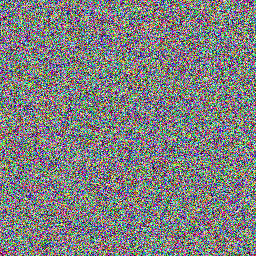

 20%|█▉        | 198/1000 [00:18<00:52, 15.38it/s]

'Image at step 200'

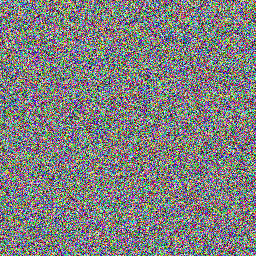

 30%|██▉       | 298/1000 [00:25<00:43, 16.10it/s]

'Image at step 300'

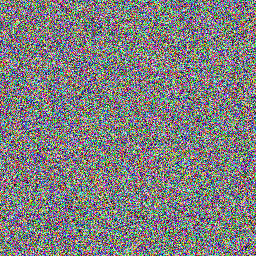

 40%|███▉      | 398/1000 [00:32<00:38, 15.57it/s]

'Image at step 400'

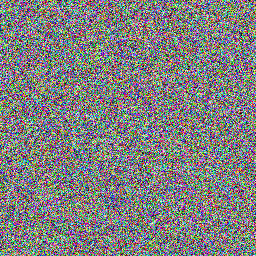

 50%|████▉     | 498/1000 [00:39<00:31, 15.82it/s]

'Image at step 500'

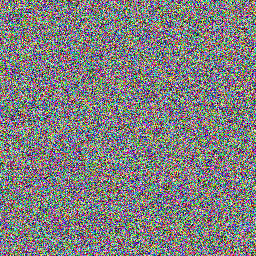

 60%|█████▉    | 597/1000 [00:46<00:26, 15.22it/s]

'Image at step 600'

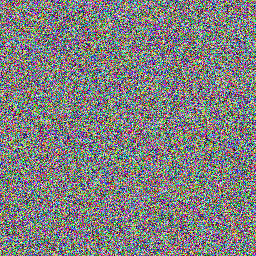

 70%|██████▉   | 699/1000 [00:53<00:21, 14.17it/s]

'Image at step 700'

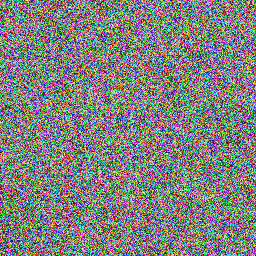

 80%|███████▉  | 798/1000 [01:00<00:14, 14.17it/s]

'Image at step 800'

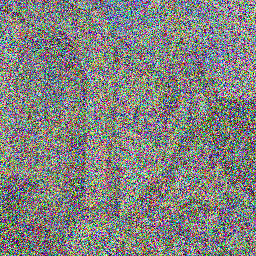

 90%|████████▉ | 899/1000 [01:07<00:07, 14.24it/s]

'Image at step 900'

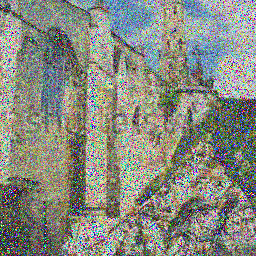

100%|█████████▉| 998/1000 [01:14<00:00, 14.14it/s]

'Image at step 1000'

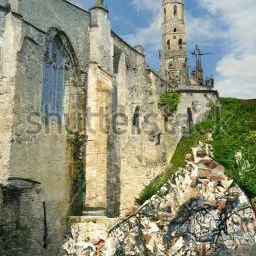

100%|██████████| 1000/1000 [01:15<00:00, 13.31it/s]


In [7]:
torch.manual_seed(0)
sample = torch.tensor(np.load("noisy_sample.npy")).to("cuda")
diffusers_scheduler = DDPMScheduler.from_config(repo_id)
for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
    # 1. predict noise residual
    with torch.no_grad():
        residual = model(sample, t).sample

    # 2. compute less noisy image and set x_t -> x_t-1
    sample = diffusers_scheduler.step(residual, t, sample).prev_sample

    # 3. optionally look at image
    if (i + 1) % 100 == 0:
        display_sample(sample, i + 1)

diffusers_sample = sample.cpu().clone()

### Here is how you use your custom Scheduler to reconstruct the image.

You should exptected your reconstructed image is the same as the Diffusers',
and if they are different, you should restart your session and rerun.

 10%|▉         | 99/1000 [00:07<01:03, 14.17it/s]

'Image at step 100'

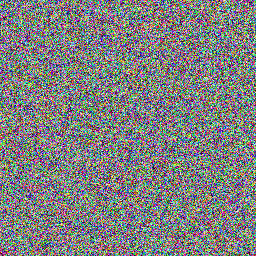

 20%|█▉        | 199/1000 [00:14<00:56, 14.16it/s]

'Image at step 200'

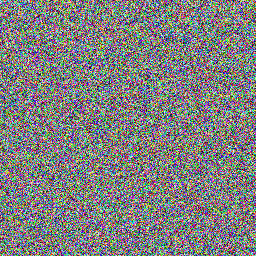

 30%|██▉       | 299/1000 [00:21<00:49, 14.18it/s]

'Image at step 300'

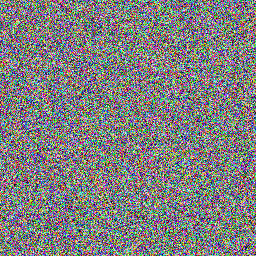

 40%|███▉      | 399/1000 [00:28<00:42, 14.14it/s]

'Image at step 400'

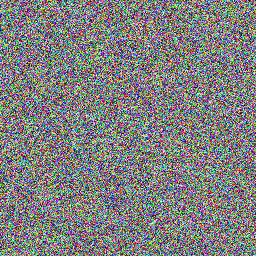

 50%|████▉     | 499/1000 [00:35<00:35, 14.15it/s]

'Image at step 500'

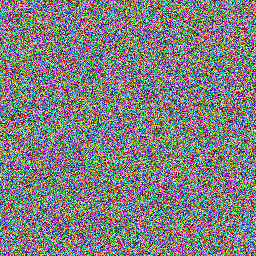

 60%|█████▉    | 599/1000 [00:42<00:28, 14.17it/s]

'Image at step 600'

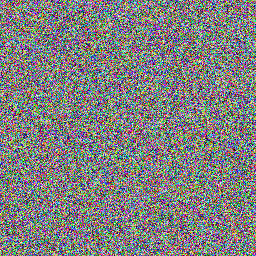

 70%|██████▉   | 697/1000 [00:46<00:11, 26.82it/s]

'Image at step 700'

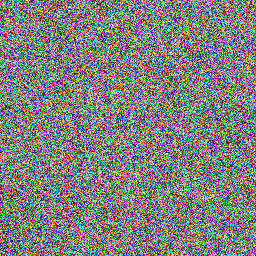

 80%|███████▉  | 799/1000 [00:50<00:07, 26.50it/s]

'Image at step 800'

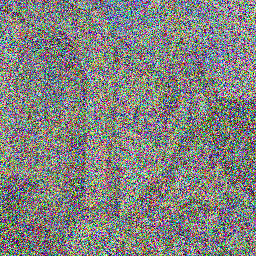

 90%|████████▉ | 898/1000 [00:53<00:03, 26.12it/s]

'Image at step 900'

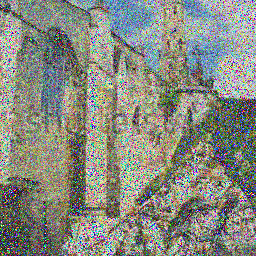

100%|█████████▉| 997/1000 [00:57<00:00, 26.94it/s]

'Image at step 1000'

In [ ]:
# q sample
torch.manual_seed(0)
scheduler = CustomDDPMScheduler_p(1000, 0.0001, 0.02)
sample = torch.tensor(np.load("noisy_sample.npy")).to("cuda")
for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
    # 1. predict noise residual
    with torch.no_grad():
        residual = model(sample, t).sample

    # 2. compute less noisy image and set x_t -> x_t-1
    sample = scheduler.step(residual, t, sample)

    # 3. optionally look at image
    if (i + 1) % 100 == 0:
        display_sample(sample, i + 1)

our_sample = sample.cpu().clone()

### Validate Your Results

Use this section to verify whether your generated results align closely with diffusers'.

Keep in mind that this validation serves solely for debugging purposes. Successfully passing this check does not guarantee a perfect score.

In [ ]:
try:
    torch.testing.assert_close(diffusers_sample, our_sample, rtol=1e-3, atol=1e-1)
except AssertionError:
    print("The two tensors are not close to each other. Try rerunning the code or find the bug.")
else:
    print("Congratulations! You have passed the test.")
    torch.allclose(diffusers_sample, our_sample, atol=1e-3)